# Introduction

# Setup
Let us import the required modules.

In [1]:
import pandas as pd
import seaborn as sns
import os
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import src.utilities.data_split as ds
from src.classifiers.knn import KNN

## Load Data
Note that the dataset is already split into Train-Test sets.

In [2]:
data_split = ds.TrainTestSplit.from_csv_directory(dir_path="../data")

In [3]:
data_split.x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 719 entries, pixel13 to pixel780
dtypes: float64(719)
memory usage: 329.1 MB


In [4]:
data_split.y_train.shape

(60000,)

# K-Nearest Neighbors Classifier Model

## Tuning Generative Classifiers

Use a smaller dataset due to the workload of GridSearchCV

In [ ]:
sns.countplot(x=data_split.y_train)

In [ ]:
x_data_small, y_data_small = ds.get_train_subset(x_train=data_split.x_train, y_train=data_split.y_train, size=5000)

<AxesSubplot:xlabel='Number', ylabel='count'>

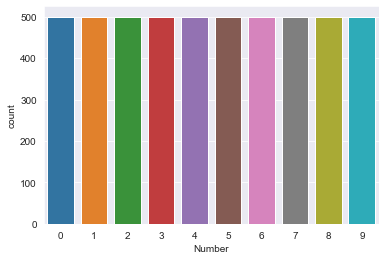

In [6]:
sns.countplot(x=y_data_small)

In [7]:
x_data_small.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 6317 to 55395
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64


In [8]:
y_data_small.shape

(5000,)

In [9]:
y_data_small

6317     0
32650    0
18465    0
52030    0
12789    0
        ..
29794    9
33134    9
29411    9
1221     9
55395    9
Name: Number, Length: 5000, dtype: int64

### Hyper-parameters tuning

In [ ]:
import time

# automatic parameters tuning
# knnclsf=KNeighborsClassifier()
knnclsf=KNN()
properties={
    "n_neighbors" : [5,10,20,35,50],
    "metric" : ['euclidean','manhattan']
}

start_time = time.time()
tuned_knnclsf=GridSearchCV(knnclsf,properties,scoring="accuracy",cv=10,return_train_score=True,verbose=5,n_jobs=4)
tuned_knnclsf.fit(x_data_small,y_data_small)
print("--- %s seconds ---" % (time.time() - start_time))

print ("Best Score: {:.3f}".format(tuned_knnclsf.best_score_) )
print ("Best Params: ", tuned_knnclsf.best_params_)

In [ ]:
# save results
if not os.path.exists('../tuned_models'):
    os.mkdir('../tuned_models')
joblib.dump(tuned_knnclsf, '../tuned_models/knn_tuning_results.pkl')

In [5]:
# to load previously saved results
tuned_knnclsf = joblib.load("../tuned_models/knn_tuning_results.pkl")

In [ ]:
print(tuned_knnclsf.cv_results_)
tuned_knnclsf_results = pd.DataFrame( tuned_knnclsf.cv_results_ )

In [ ]:
tuned_knnclsf_results[["params","mean_test_score","mean_train_score"]]

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_knnclsf_results, x="param_n_neighbors", y="mean_test_score")

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_knnclsf_results, x="param_metric", y="mean_test_score")

In [ ]:
print(tuned_knnclsf.best_estimator_)
print(tuned_knnclsf.best_score_)

In [ ]:
test_acc = accuracy_score(y_true = data_split.y_train,
                    y_pred = tuned_knnclsf.predict(data_split.x_train))
print ("Train accuracy Score on original dataset: {}".format(test_acc) )

In [16]:
# best parameters from automatic parameters tuning
# knn_clsf = KNN(**tuned_knnclsf.best_params_)
knn_clsf = KNN(n_neighbors=10, metric="manhattan")
knn_clsf.fit(data_split.x_train, data_split.y_train)

KNN(k=10, metric='manhattan')

In [17]:
knn_try_pred = knn_clsf.predict(x_data_small)

In [18]:
print('trial Accuracy Score: {}'.format(accuracy_score(y_true = y_data_small,
                                           y_pred = knn_try_pred)))
# funziona, ma ci mette 50 min se metto 10000 entries, fai meno plis, e meno modelli nel gridsearch

trial Accuracy Score: 0.9688409744282103


In [ ]:
knn_train_pred = knn_clsf.predict(data_split.x_train)
knn_test_pred = knn_clsf.predict(data_split.x_test)

In [15]:
print("Training:")
print('Accuracy Score: {}'.format(accuracy_score(y_true = data_split.y_train,
                                           y_pred = knn_train_pred)))

Training:
Accuracy Score: 0.9341333333333334


In [16]:
print("Testing:")
print('Accuracy Score: {}'.format(accuracy_score(y_true = data_split.y_test,
                                           y_pred = knn_test_pred)))

Testing:
Accuracy Score: 0.9251


# Performance Visualization

### Setup